
# Linear Algebra Examples

**Learning goals**
1. See how linear algebra models real mechanical systems (spring–mass).
2. Use eigenvalues/eigenvectors to simulate the dynamics of the system.


## Modeling a 2‑Mass, 3‑Spring System

**System:** 
Two masses (denoted as $m_1$ and $m_2$) are connected by three springs 
(with spring constants $k_1, k_2, k_3$) to walls and to each other.

<div style="text-align: center;">
    <img src="../../data/springs_and_masses.png" alt="Springs and Masses" width="800">
</div>

For this system, we will denote the displacements of the masses 
(with their respective equilibrium positions) as $x_1$ and $x_2$.

Then the equations of motion are given by:

$$
\begin{aligned}
m_1 \ddot x_1 + (k_1+k_2)\,x_1 - k_2\,x_2 &= 0,\\
m_2 \ddot x_2 + (k_2+k_3)\,x_2 - k_2\,x_1 &= 0.
\end{aligned}
$$

This can be written in matrix form as:

$$
\underbrace{\begin{bmatrix} m_1 & 0 \\ 0 & m_2 \end{bmatrix}}_{M}
\begin{bmatrix} \ddot x_1 \\ \ddot x_2 \end{bmatrix}
+
\underbrace{\begin{bmatrix} k_1+k_2 & -k_2 \\ -k_2 & k_2+k_3 \end{bmatrix}}_{K}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
= \mathbf{0}.
$$

with effective mass matrix $M$ and stiffness matrix $K$.

Let's further denote $\mathbf{x}(t)=[x_1(t),\,x_2(t)]^\top$, and
$\mathbf{z}=\begin{bmatrix}\mathbf{x}\\ \dot{\mathbf{x}}\end{bmatrix}\in\mathbb{R}^4$
as the state vector. Then the system can be written as:

$$
\dot{\mathbf{z}} = \underbrace{\begin{bmatrix} 0 & I \\ -M^{-1}K & 0 \end{bmatrix}}_{\mathbf{A}} \mathbf{z}.
$$

with the immediate solution of 

$$
\mathbf{z}(t)=e^{At}\,\mathbf{z}(0).
$$

## Generalized eigen-problem

Take any eigenvalue and eigenvector pair $(\lambda,\;v)$ of $A$ with $v\neq 0$. Split the state eigenvector into displacements and velocities:

$$
v=\begin{bmatrix}u\\ w\end{bmatrix},\qquad u,w\in\mathbb{R}^2.
$$

The equation $A v=\lambda v$ gives the block relations

$$
\begin{cases}
w=\lambda u,\\[4pt]
-\,M^{-1}K\,u=\lambda w.
\end{cases}
$$

We can eliminate $w$ (by substituting $w=\lambda u$) to arrive at the generalized eigen-problem in $u$

$$
-\,M^{-1}K\,u=\lambda(\lambda u)=\lambda^2 u
\quad\Rightarrow\quad
K\,u = -\,\lambda^2 M\,u.
$$

Let $\omega^2 = -\,\lambda^2$ (i.e., $\lambda=\pm j\omega$). Then

$$
\boxed{\,K\,u=\omega^2 M\,u\,}
$$

which is exactly the **generalized eigenproblem** for the undamped system. Thus:

* $u$ is (proportional to) the **displacement mode shape** $\phi$.
* $\omega$ is the corresponding **natural frequency**.

## Numerical examples

In the following, we will use numerical examples to illustrate the dynamics of the system.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

def build_mk(
    m1: float,
    m2: float,
    k1: float,
    k2: float,
    k3: float
) -> tuple[np.ndarray, np.ndarray]:
    """Build the mass and stiffness matrices for a 2-mass, 3-spring system.

    Args:
        m1: mass of the first mass
        m2: mass of the second mass
        k1: spring constant of the first spring
        k2: spring constant of the second spring
        k3: spring constant of the third spring

    Returns:
        M: mass matrix
        K: stiffness matrix
    """
    M = np.array([[m1, 0.0],
                  [0.0, m2]], dtype=float)
    K = np.array([[k1 + k2, -k2],
                  [-k2, k2 + k3]], dtype=float)
    return M, K


def modal_analysis(
    M: np.ndarray,
    K: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """
    Solve the generalized eigen-problem.

    Args:
        M: mass matrix
        K: stiffness matrix

    Returns:
        omega: natural frequencies (rad/s), shape (2,)
        Phi: mass-normalized mode matrix (columns are modes), shape (2,2)
    """
    M_inv = np.linalg.inv(M)
    A = M_inv @ K
    omega_squared, Phi = np.linalg.eig(A)

    # Ensure real values (numerical noise tolerance)
    omega_squared = np.real(omega_squared)
    Phi = np.real(Phi)

    # Sort by increasing frequency
    idx = np.argsort(omega_squared)
    omega_squared = omega_squared[idx]
    Phi = Phi[:, idx]

    # Mass-normalize mode shapes using vectorized operations
    modal_masses = np.diag(Phi.T @ M @ Phi)  # Compute all modal masses at once
    Phi = Phi / np.sqrt(modal_masses)  # Broadcasting normalization

    return np.sqrt(omega_squared), Phi

def time_response(
    M: np.ndarray,
    K: np.ndarray,
    Phi: np.ndarray,
    Omega: np.ndarray,
    x0: np.ndarray,
    v0: np.ndarray,
    t: np.ndarray
) -> np.ndarray:
    """
    Compute x(t) = Phi [cos(Omega t) Phi^T M x0 + Omega^{-1} sin(Omega t) Phi^T M v0]
    where Omega = diag(omega_1, omega_2).

    Args:
        M: mass matrix
        K: stiffness matrix
        Phi: mode matrix
        Omega: natural frequencies
        x0: initial displacement
        v0: initial velocity
        t: time array

    Returns:
        X: displacement history, shape (len(t), 2)
    """
    # Initial conditions in modal coordinates
    q0 = Phi.T @ M @ x0
    dq0 = Phi.T @ M @ v0
    Omega = Omega.reshape(-1)  # (2,)

    # mode-wise cos/sin
    cosine_ = np.cos(np.outer(Omega, t))  # (2, T)
    sine_ = np.sin(np.outer(Omega, t))  # (2, T)

    # assemble modal coordinates
    Q = (cosine_ * q0[:, None]) + (sine_ * (dq0 / Omega)[:, None])  # (2, T)
    # back to physical coords
    X = (Phi @ Q).T  # (T,2)

    return X

def demo(
    m1: float,
    m2: float,
    k1: float,
    k2: float,
    k3: float,
    x0: np.ndarray,
    v0: np.ndarray,
    t: np.ndarray
) -> None:
    """Demonstrate the dynamics of a 2-mass, 3-spring system."""
    M, K = build_mk(m1, m2, k1, k2, k3)
    w, Phi = modal_analysis(M, K)
    X = time_response(M, K, Phi, w, x0, v0, t)

    # Plot x1(t) and x2(t) in a single chart
    plt.figure()
    plt.plot(t, X[:, 0], label="x1(t)")
    plt.plot(t, X[:, 1], label="x2(t)")
    plt.title(f"Time response")
    plt.xlabel("time (s)")
    plt.ylabel("displacement (m)")
    plt.legend()
    plt.grid(True)
    plt.show()


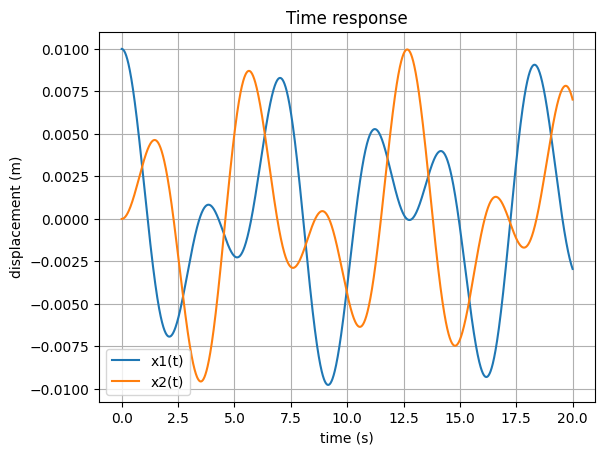

In [2]:
# Demo
t = np.linspace(0.0, 20.0, 2001)  # 2 seconds at 1 kHz
x0 = np.array([0.01, 0.0])  # 1 cm initial displacement on mass 1
v0 = np.array([0.0, 0.0])  # zero initial velocities

demo(m1=1.0, m2=1.0, k1=1.0, k2=1.0, k3=1.0, x0=x0, v0=v0, t=t)
